# Bayesian pooled polling charts

## Set-up

In [1]:
# system imports
import itertools
from pathlib import Path

# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Useful to check
import pytensor as pt
print(f"Running on pytensor v{pt.__version__}")

import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on pytensor v2.26.4
Running on PyMC v5.19.1


In [3]:
# local import
import bayes_tools
import plotting
from common import MIDDLE_DATE, VOTING_INTENTION, ensure
from data_capture import retrieve

In [4]:
# plotting related
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

SHOW = True  # show charts in the notebook
SHOW_MODEL_MAPS = False  # show model maps in notebook

## Get data

In [5]:
data = retrieve()
ensure(data, "You must run the data capture notebook every day.")
print(f"Latest poll (mean date): {data['voting-intention'].iloc[:, -2].max()}")
print(f"Data columns:\n{data['voting-intention'].columns}")
print(f"Poll count by pollster:\n{data['voting-intention']['Brand'].value_counts().sort_index()}")

Latest poll (mean date): 2024-12-06
Data columns:
Index(['Date', 'Brand', 'Interview mode', 'Sample size', 'Primary vote L/NP',
       'Primary vote ALP', 'Primary vote GRN', 'Primary vote ONP',
       'Primary vote UAP', 'Primary vote OTH', '2pp vote ALP', '2pp vote L/NP',
       'First Date', 'Mean Date', 'Last Date'],
      dtype='object')
Poll count by pollster:
Brand
DemosAU                 1
Dynata                  1
Essential              21
Essential 2            27
Freshwater Strategy    15
Newspoll               30
Newspoll-YouGov         3
RedBridge Group         9
Resolve Strategic      17
Resolve Strategic 2    11
Roy Morgan             63
Wolf & Smith            1
YouGov                 15
Name: count, dtype: int64


In [6]:
previous = pd.read_csv("../historic-data/election-outcomes.csv", sep="\\s+", na_values="-", comment='#')
previous = previous.dropna(how="all")
coalition = ["LP", "LNP", "NP", "CLP"]
previous['Primary vote L/NP'] = previous[coalition].sum(axis=1)
previous['Primary vote Other'] = 100.0 - previous['Primary vote L/NP'] - previous['ALP'] - previous['GRN']
previous['Primary vote ALP'] = previous["ALP"]
previous["Primary vote GRN"] = previous["GRN"]
previous["2pp vote L/NP"] = 100.0 - previous["Labor2pp"]
previous["2pp vote ALP"] = previous["Labor2pp"]
drop = ["Others", "ON", "UAP", "DEM", "DLP", "GRN", "ALP", "Labor2pp"] + coalition
previous = previous.drop(columns=(drop)).iloc[-1]
previous


Year                         2022
Date                  21-May-2022
GovtBefore              Coalition
GovtAfter                   Labor
Primary vote L/NP           35.69
Primary vote Other          19.48
Primary vote ALP            32.58
Primary vote GRN            12.25
2pp vote L/NP               47.87
2pp vote ALP                52.13
Name: 29, dtype: object

## Do the Bayesian pooling ...

### The selection of charts to plot

In [ ]:
# --- select the charts we will produce ...
#     You can choose:
#     - whether to use fixed priors and/or prior distributions
#     - whether to use a Normal and/or StudentT likelihoods
#     - whether to use the GP, GRW and/or GRWLA models
#       where GP = Gaussian Process, GRW = Gaussian
#       Random walk, and GRWLA is a left anchored GRW.

fixed_priors = False, True
likelihoods = "Normal", "StudentT"
approaches = "GRW", "GRWLA", "GP"

# analysis options for selected_analysis below
complete_set = tuple(itertools.product(fixed_priors, likelihoods, approaches))
fixed_normal_only = tuple(x for x in complete_set if x[0] and x[1] == "Normal")
fixed_student_only = tuple(x for x in complete_set if x[0] and x[1] == "StudentT")
fixed_gp_only = tuple(x for x in complete_set if x[0] and x[2] == "GP")
not_fixed_gp_only = tuple(x for x in complete_set if not x[0] and x[2] == "GP")
not_fixed_grw_only = tuple(x for x in complete_set if not x[0] and "GRW" in x[2])
fixed__normal_gp_grw = tuple(x for x in complete_set if x[0] and x[1] == "Normal" and x[2] in ("GP", "GRW"))
fixed_normal_grw_only = tuple(x for x in complete_set if x[0] and x[1] == "Normal" and x[2] == "GRW")

selected_analysis = fixed_normal_grw_only
#selected_analysis = fixed__normal_gp_grw   # gp has stopped working - not sure why - 10/12/2024

### Identify columns to analyze and plot

In [8]:
# identify the columns we will analyze ...
df = plotting.amalgamate_other(data[VOTING_INTENTION])
frame = ("2pp", "Primary vote")
columns = sorted([x for x in df.columns if any(item in x for item in frame)])
MAJORS = ("ALP", "L/NP")
MINORS = ("GRN", "Other")
to_chart = MAJORS + MINORS

# column options for selected_columns below
all_columns = [c for c in columns if any(item in c for item in to_chart)]
alp_only = [c for c in all_columns if "ALP" in c]
lnp_only = [c for c in all_columns if "L/NP" in c]
tpp_only = [f"2pp vote {x}" for x in MAJORS]
primary_only = [x for x in all_columns if frame[1] in x]
alp_2pp_only = ["2pp vote ALP"]
most_columns = alp_2pp_only + primary_only  # ignores "2pp vote L/NP"
minors_pv_only = [f"Primary vote {x}" for x in MINORS]
majors_pv_only = [f"Primary vote {x}" for x in MAJORS]

selected_columns = all_columns
print(f"Selected columns: {selected_columns}")

Selected columns: ['2pp vote ALP', '2pp vote L/NP', 'Primary vote ALP', 'Primary vote GRN', 'Primary vote L/NP', 'Primary vote Other']


### Decide whether to plot residuals

In [9]:
# Residuals for infividual polls from the bayesian aggregation
# A sperate plot for each pollster

PLOT_RESIDUALS = False

### Values of the fixed priors

In [10]:
# a useful bag of fixed priors
assumed_sample_size = 750  # assume smallish effective sample
# sizes polling data is way noisier
# than published sample size suggest.
fixed_priors = {
    # --- GRW only fixed priors
    "innovation": 0.175,  # only used with GRW
    # --- GP only fixed priors
    "length_scale": 40,
    "eta": 1.6,
    # --- both GP and GRW fixed priors
    "nu": 10,  # used in StudentT likelihood
    "sigma_likelihood": np.sqrt((50.0 * 50.0) / assumed_sample_size),
}

### Exclusions from the sum-to-zero constraint on house effects

In [11]:
EXCLUDE = True
MIN_POLL_COUNT = 5 # minimum number of polls to include a pollster in the sum-to-zero constraint

he_sum_exclusions: list[str] 
if EXCLUDE:
    # (1) exclude pollsters that changed their methodology, presumably
    # they believe their earlier methodology is in some way deficient.
    exclude_base = ['Resolve Strategic', 'Essential']

    # (2) exclude pollsters with less than MIN_POLL_COUNT polls
    # This means odd, one-off polls will not effect the positioning 
    # of the poll aggregation
    pollster_counts = data['voting-intention']['Brand'].value_counts()
    exclude_counts = pollster_counts[pollster_counts < MIN_POLL_COUNT].index.tolist()
    he_sum_exclusions = list(set(exclude_base + exclude_counts))  # ensue no duplicates
    print(f"Excluding {len(he_sum_exclusions)} pollsters from the sum-to-zero constraint.")
    print(f"Excluded pollsters: {he_sum_exclusions}")
    print(f"Included pollsters: {set(data['voting-intention']['Brand']) - set(he_sum_exclusions)}")
else:
    he_sum_exclusions = []

Excluding 6 pollsters from the sum-to-zero constraint.
Excluded pollsters: ['Dynata', 'Essential', 'DemosAU', 'Newspoll-YouGov', 'Resolve Strategic', 'Wolf & Smith']
Included pollsters: {'Essential 2', 'YouGov', 'Newspoll', 'RedBridge Group', 'Freshwater Strategy', 'Resolve Strategic 2', 'Roy Morgan'}


### Key outcomes at the 2022 election

In [12]:
# constants for the left anchored model (GRWLA)
ELECTION_DATE = pd.Period("2022-05-21", freq="D")
last_election_result = {
    "2pp vote ALP": 52.13,
    "2pp vote L/NP": 47.87,
    "Primary vote ALP": 32.58,
    "Primary vote GRN": 12.25,
    "Primary vote L/NP": 35.69,
    "Primary vote Other": 19.48,
}

### Sampler settings

In [13]:
N_CORES: int = 4
SAMPLES: int = 10_000
EXTRA_SAMPLES: int = 25_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
ESAMPLES_PER_CORE: int = int(EXTRA_SAMPLES / N_CORES)
TUNE: int = 1_000

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
}

SAMPLE_ARGS

{'draws': 2500,
 'tune': 1000,
 'cores': 4,
 'chains': 4,
 'nuts_sampler': 'numpyro'}

### Do the analysis and produce the plots

2pp vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2411.0
Divergences: 0


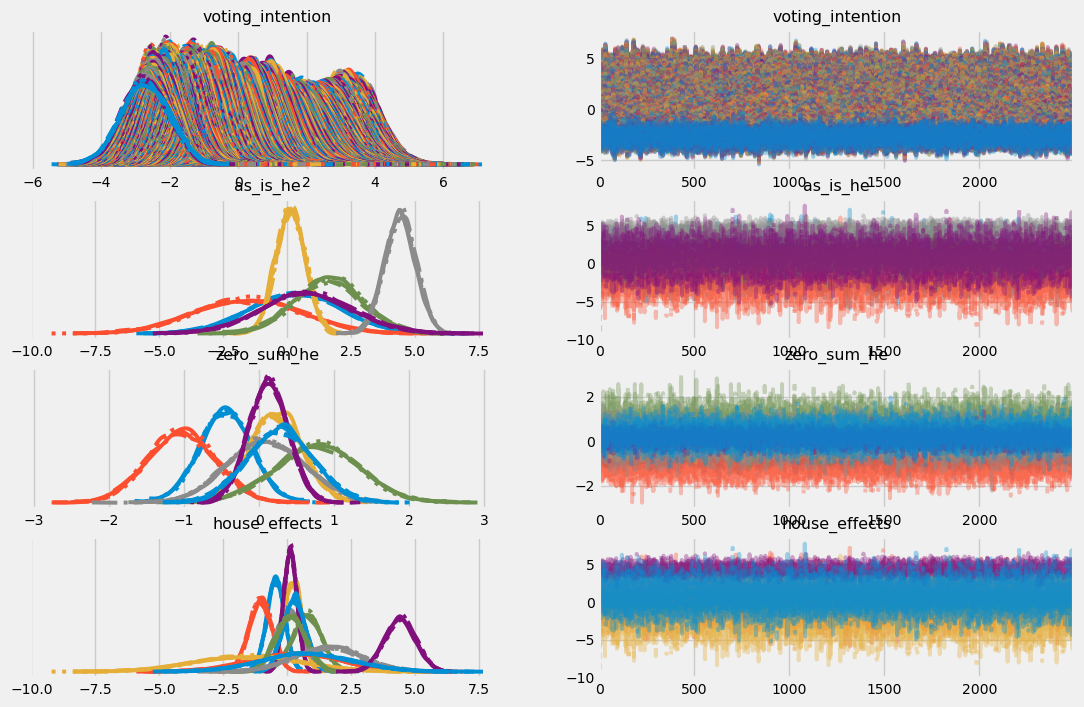

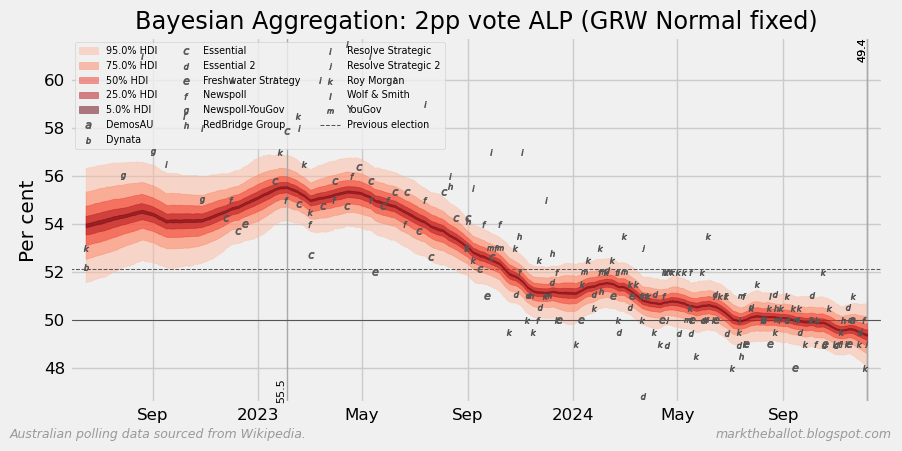

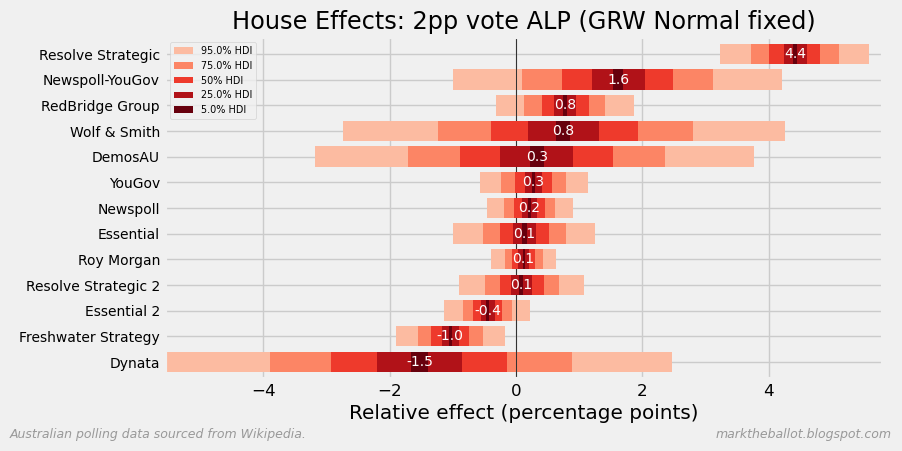

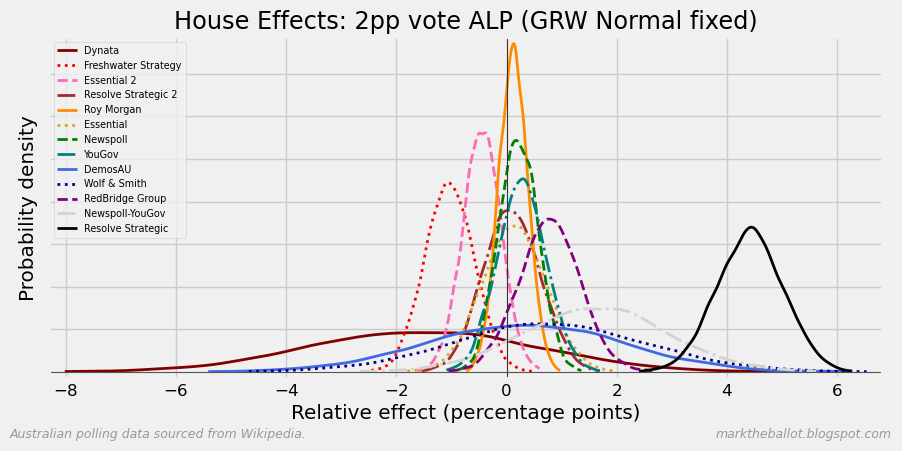

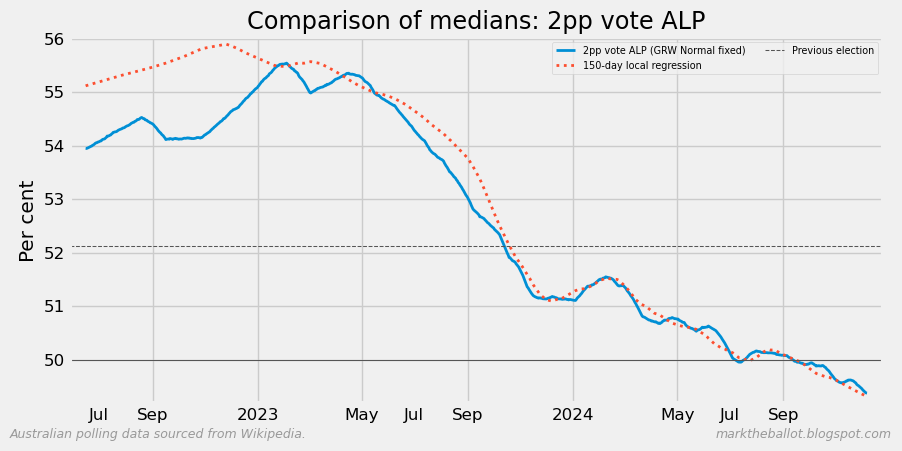

2pp vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2875.0
Divergences: 0


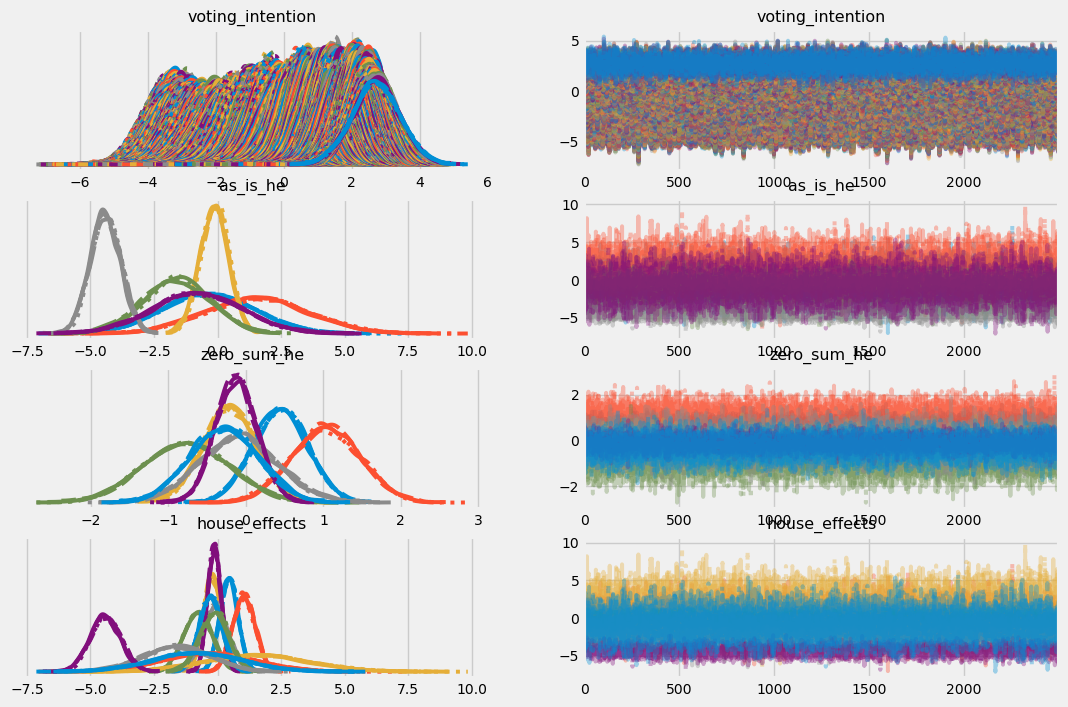

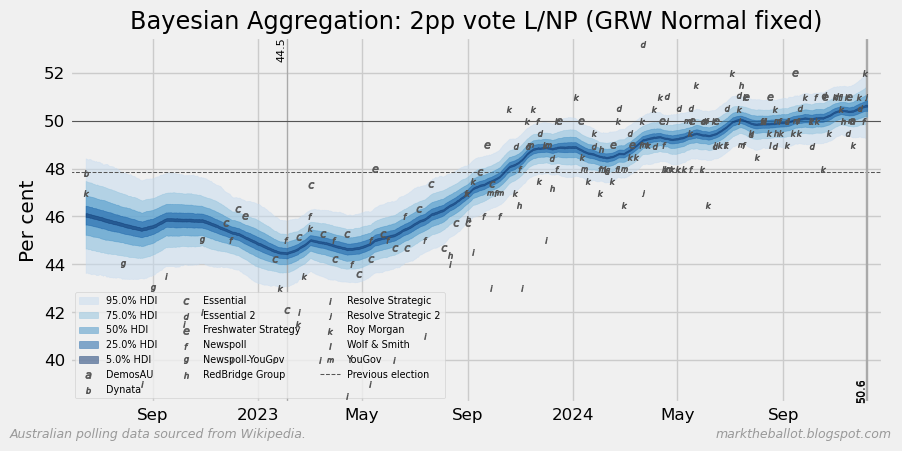

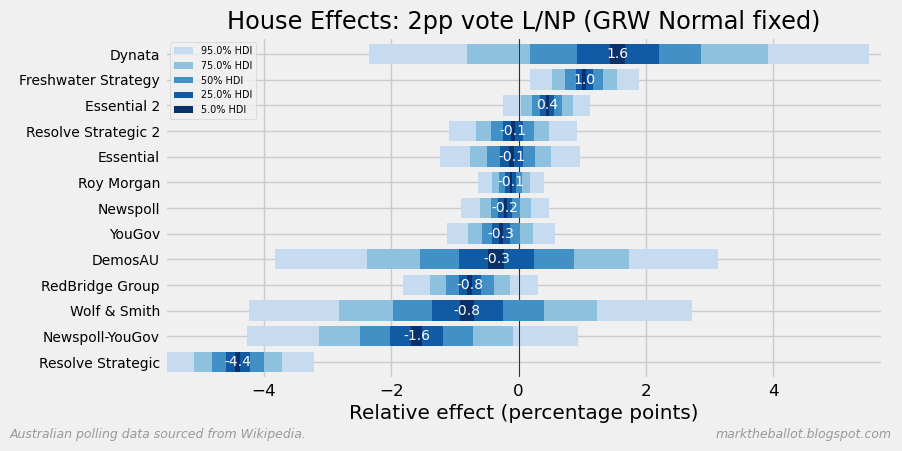

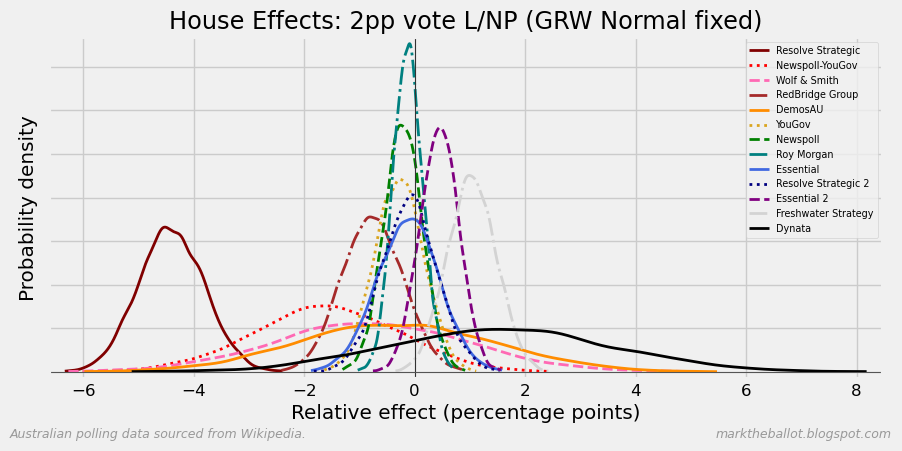

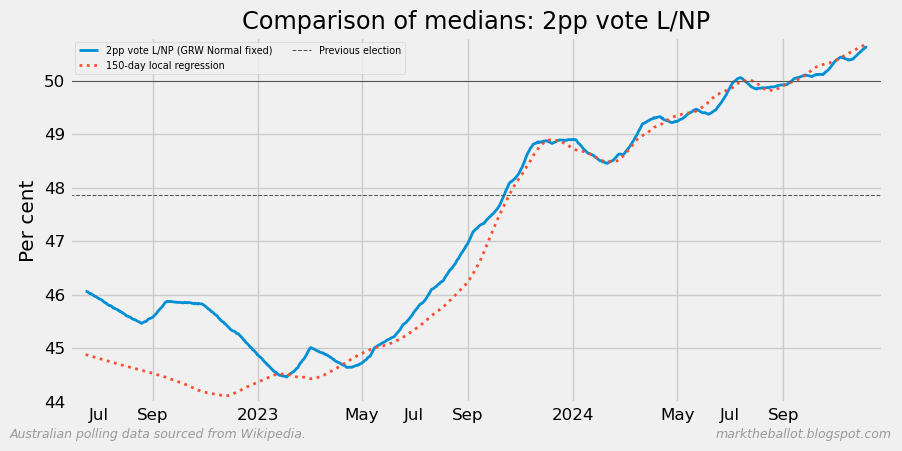

Primary vote ALP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2814.0
Divergences: 0


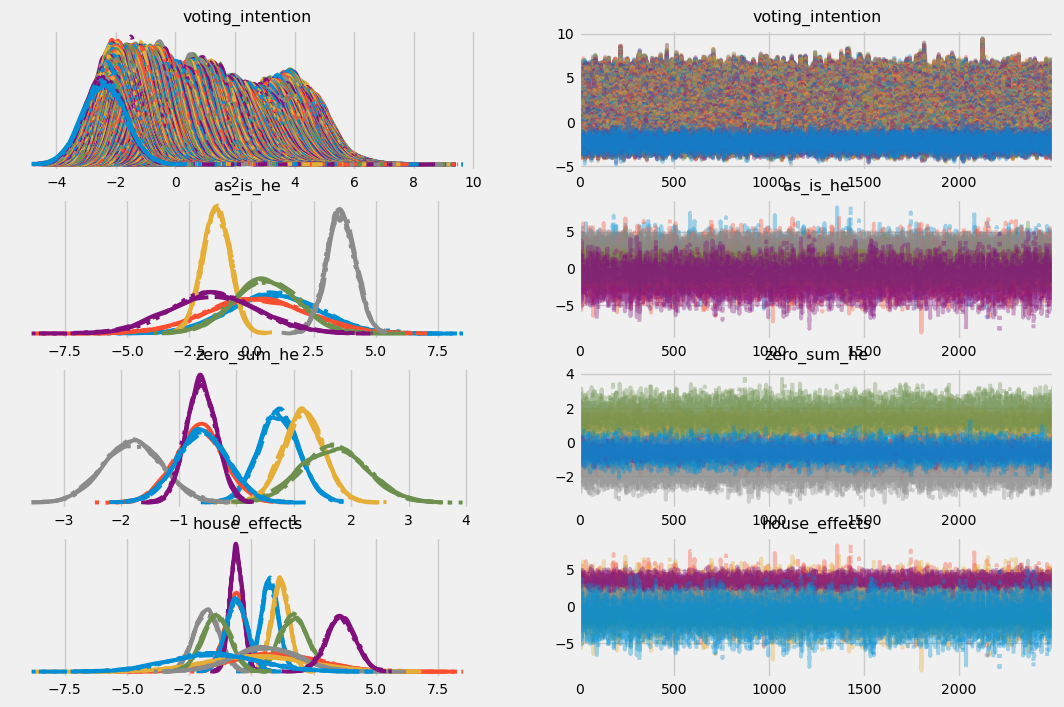

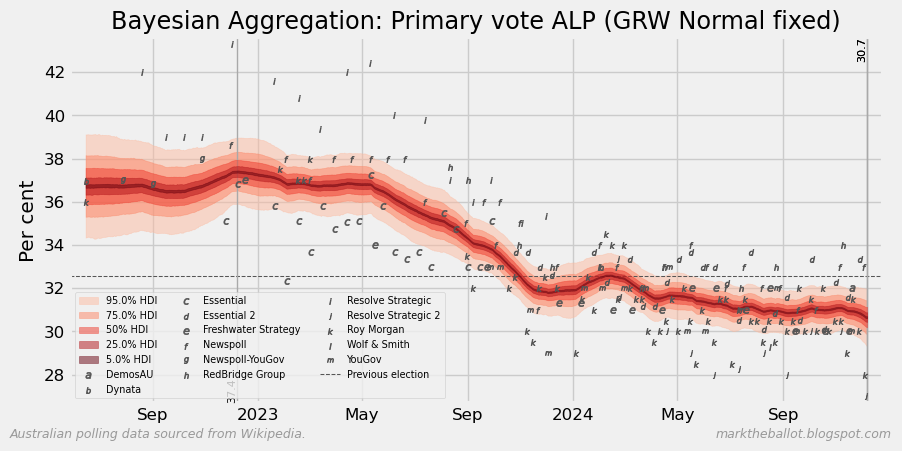

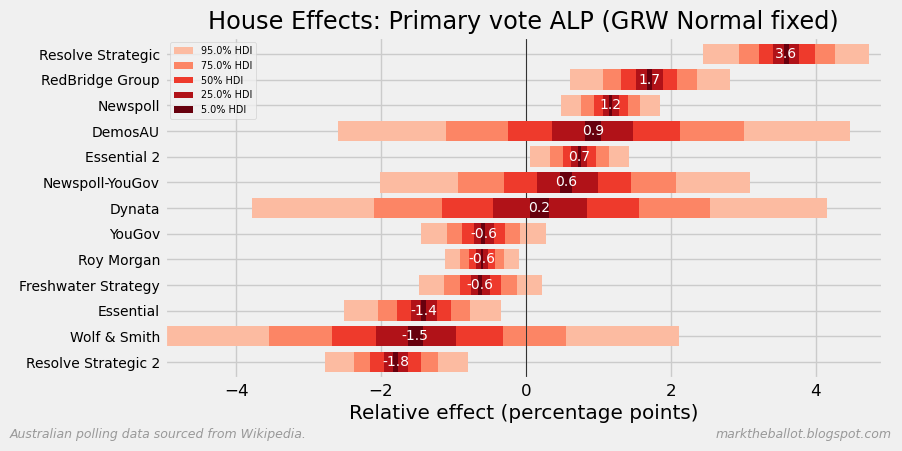

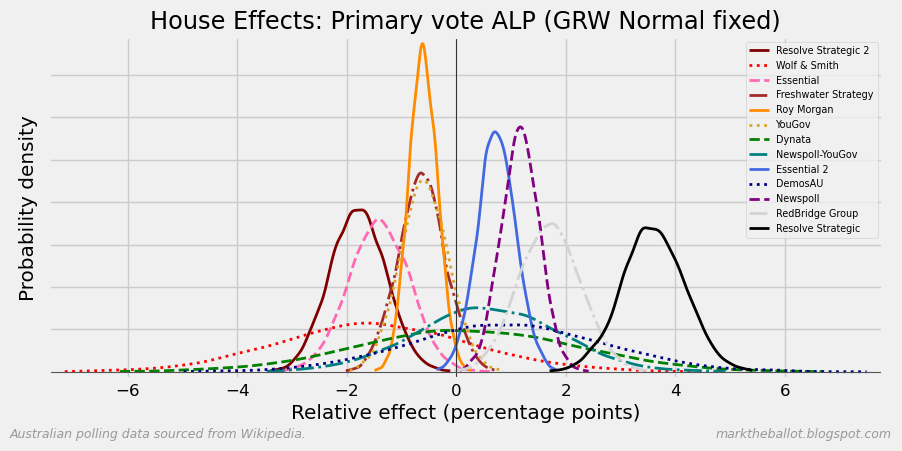

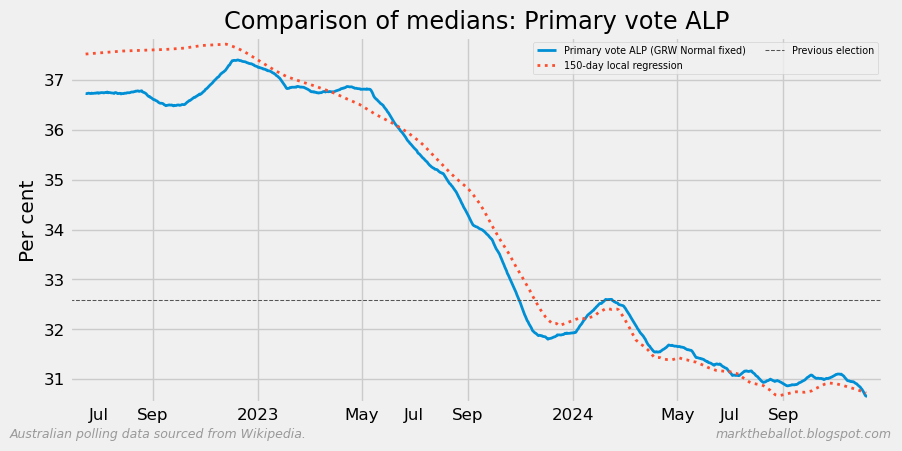

Primary vote GRN (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2791.0
Divergences: 0


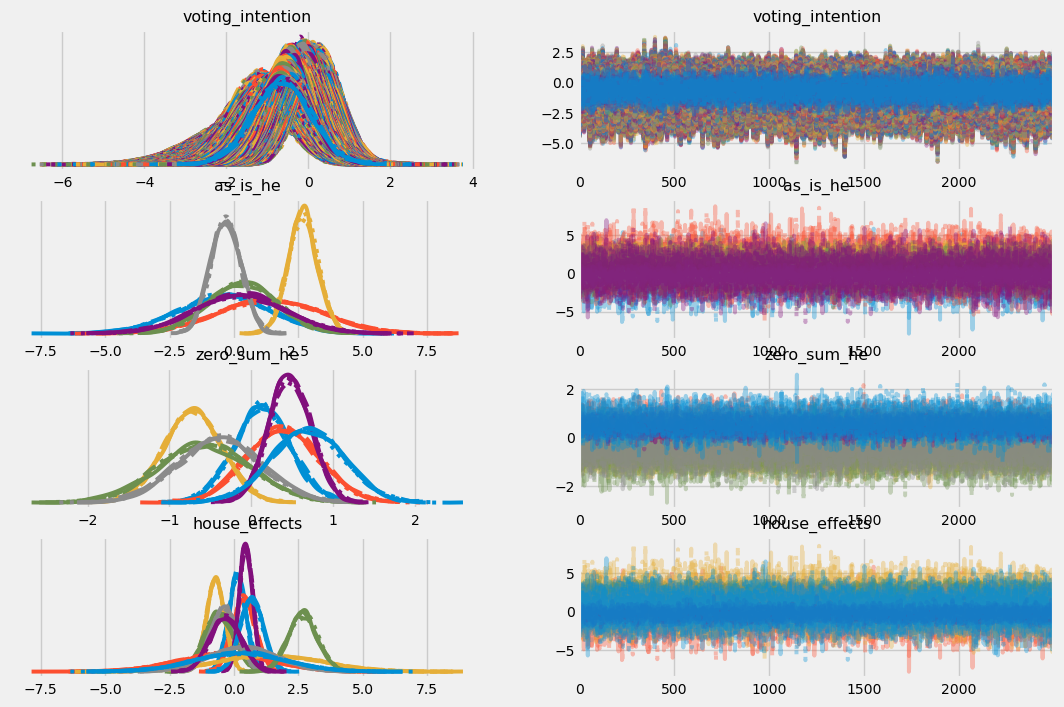

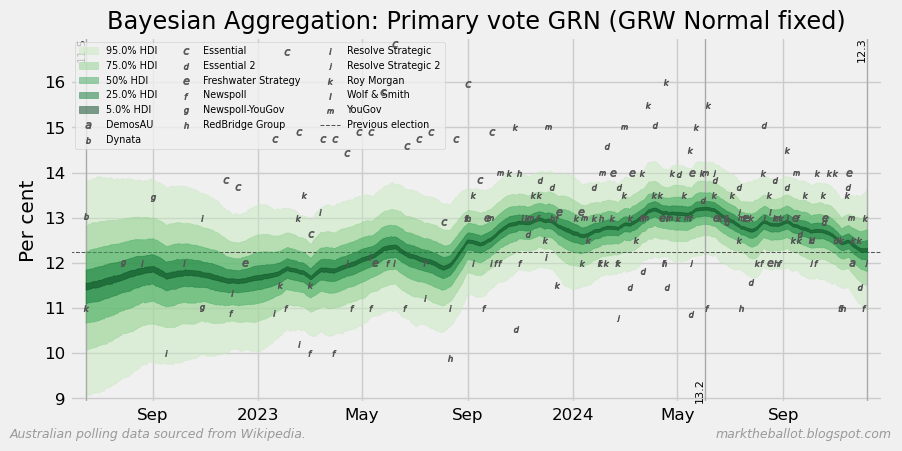

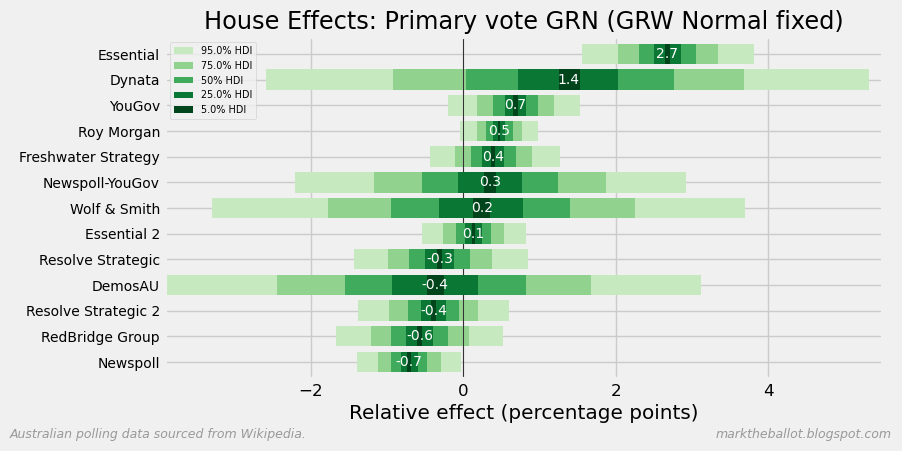

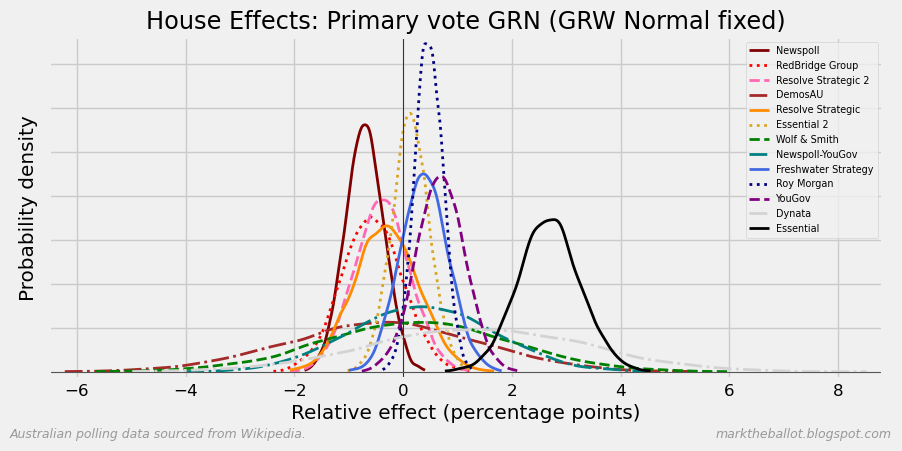

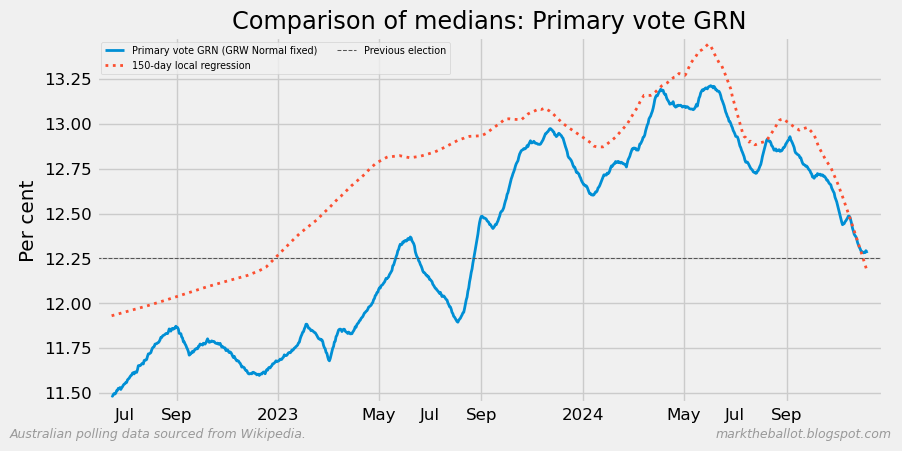

Primary vote L/NP (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2985.0
Divergences: 0


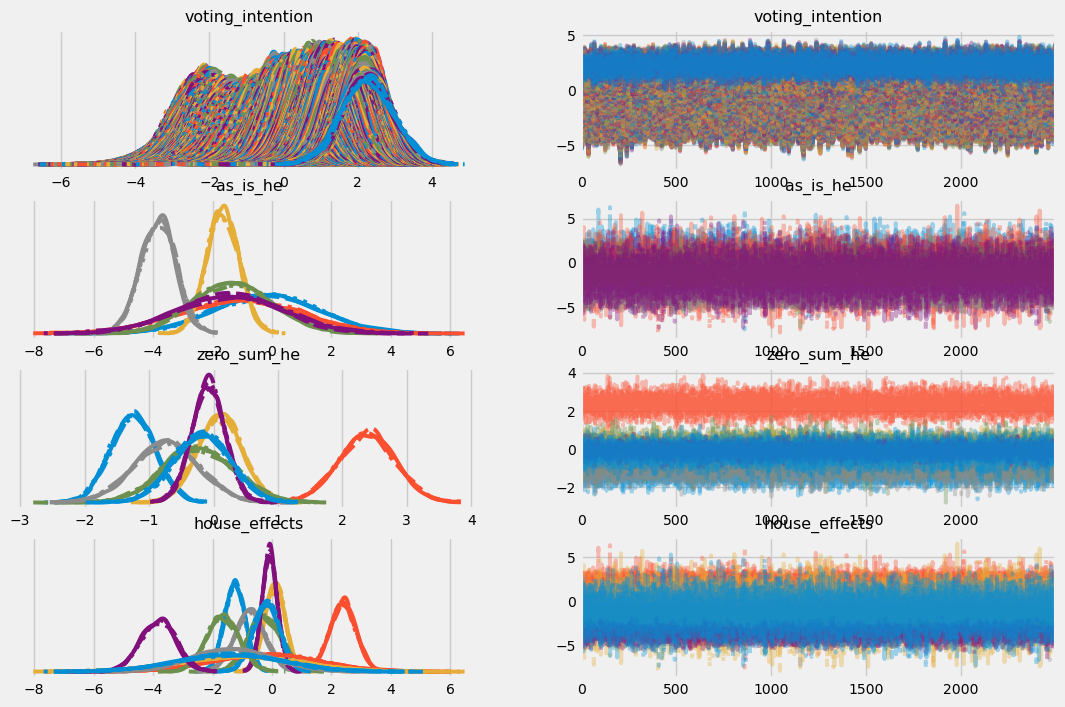

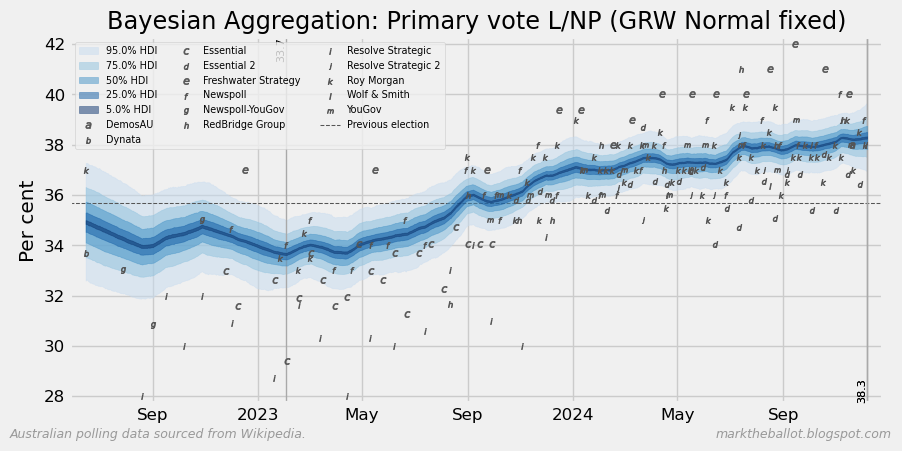

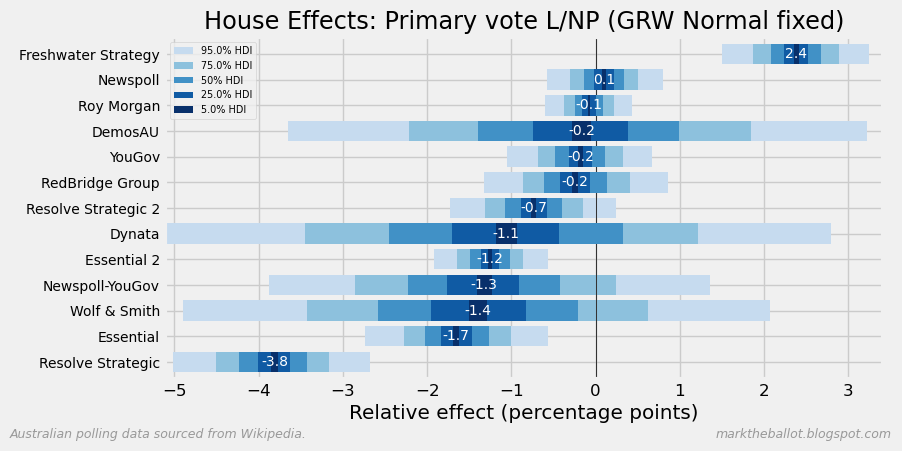

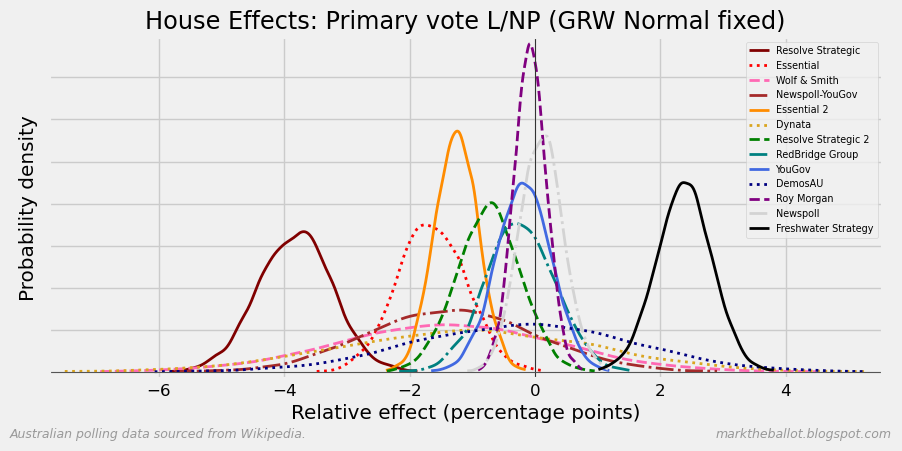

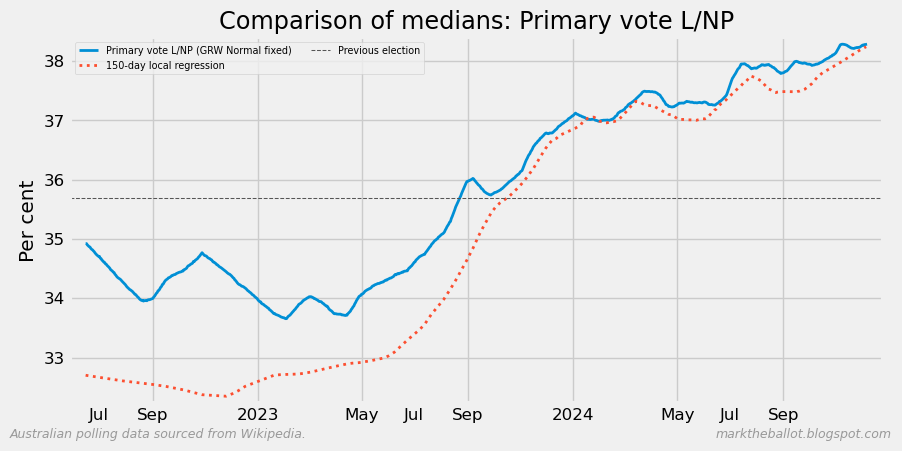

Primary vote Other (GRW Normal fixed)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/312/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,2500,6]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Max r_hat: 1.0
Min ess: 2981.0
Divergences: 0


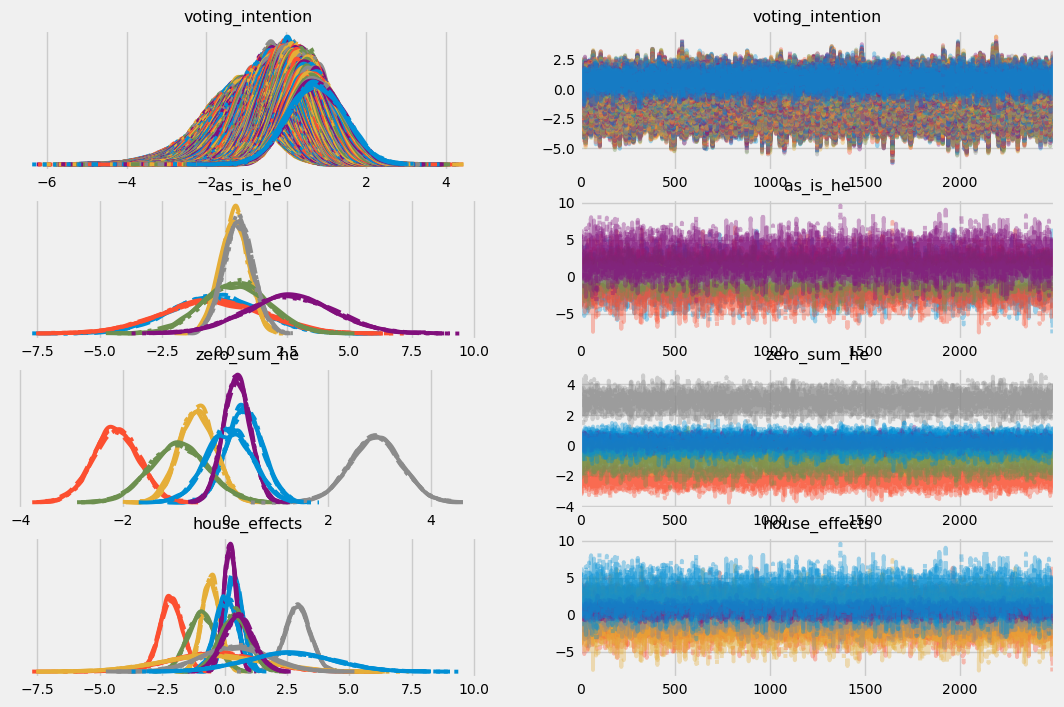

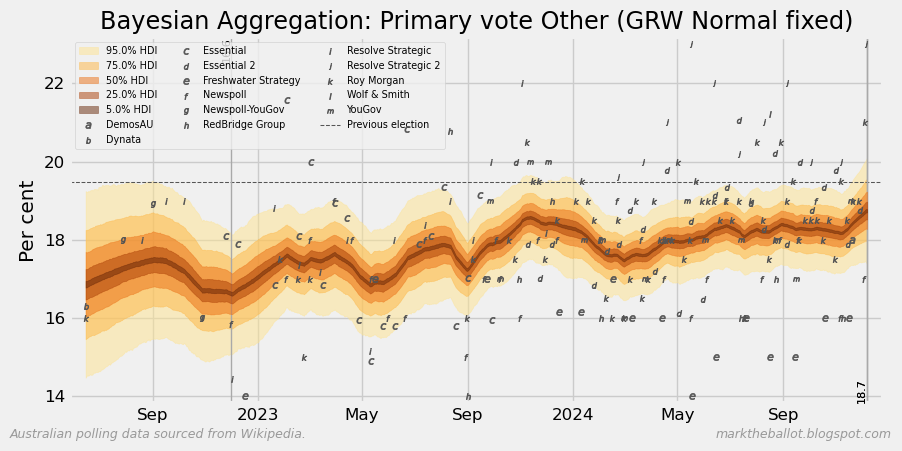

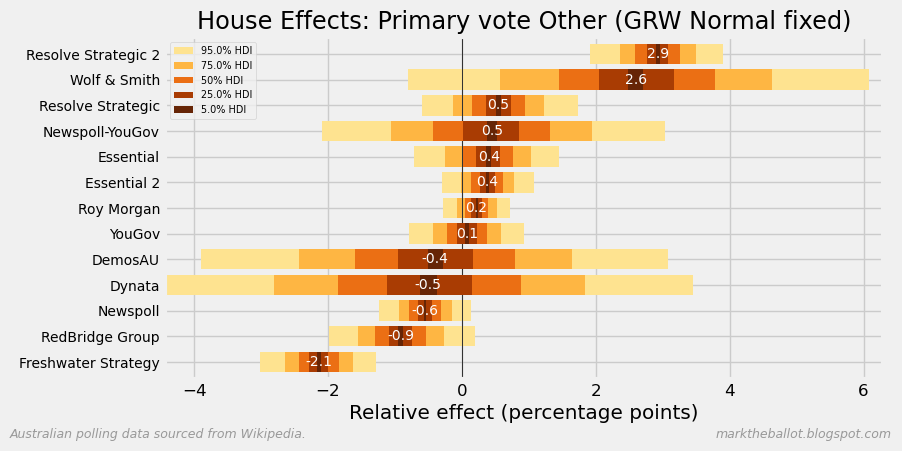

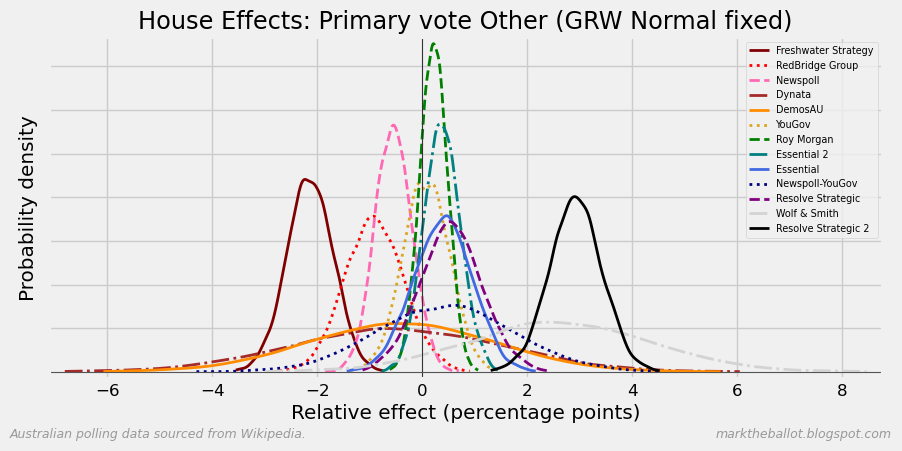

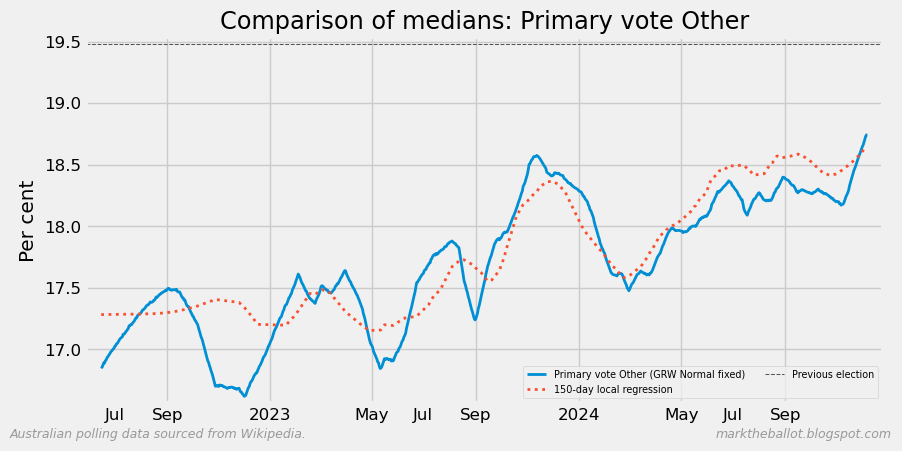

In [14]:
# --- do the analysis
for column in selected_columns:
    median_sets = {}

    for fixed, likelihood, approach in selected_analysis:
        fixed_text = "fixed" if fixed else "free"
        model_title = f"{column} ({approach} {likelihood} {fixed_text})"
        print(model_title)

        # -- get the relevant data then select and run the model
        # Note: I could not get the GRW to mix well without specifying innovation.
        #       Similarly, specifying sigma_likelihood is useful.
        keep_fixed = ("innovation", "sigma_likelihood")
        priors = fixed_priors if fixed else {x: fixed_priors[x] for x in keep_fixed}
        sampling = SAMPLE_ARGS.copy()

        match approach:
            case "GP":
                inputs = bayes_tools.prepare_data_for_analysis(
                    df, column, jitter_dates=True, tail_centred=10,
                    he_sum_exclusions=he_sum_exclusions,
                    verbose=False,
                )
                model = bayes_tools.gp_model(
                    inputs,
                    **priors,
                    likelihood=likelihood,
                    grw=False,
                    eta_prior="HalfCauchy",  # only used if eta not in **priors
                )
            case "GRW":
                inputs = bayes_tools.prepare_data_for_analysis(
                    df, column, he_sum_exclusions=he_sum_exclusions,
                    verbose=False,
                )
                model = bayes_tools.grw_model(inputs, **priors, likelihood=likelihood)
            case "GRWLA":
                inputs = bayes_tools.prepare_data_for_analysis(
                    df,
                    column,
                    left_anchor=(ELECTION_DATE, last_election_result[column]),
                    he_sum_exclusions=he_sum_exclusions,
                    verbose=False,
                )
                sampling |= {"draws": ESAMPLES_PER_CORE, "nuts": {"max_treedepth": 12}}
                model = bayes_tools.grw_la_model(
                    inputs, **priors, likelihood=likelihood
                )
            case _:
                print("Unknown approach")
                continue

        bayes_tools.generate_model_map(
            model=model,
            filemame_stem=model_title,
            model_dir=MODEL_DIR,
            display_images=SHOW_MODEL_MAPS,
        )

        idata, glitches = bayes_tools.draw_samples(model, **sampling)

        middle = bayes_tools.plot_std_set(
            inputs,
            idata,
            previous[column],
            title_stem=model_title,
            glitches=glitches,
            residuals=PLOT_RESIDUALS,
            show=SHOW,
        )
        if not glitches:
            median_sets[model_title] = middle

    # Add a local regression to the combined plot
    period = 150  # days
    median_sets[f"{period}-day local regression"] = plotting.calculate_lowess(
        series=pd.Series(df[column].values, index=df[MIDDLE_DATE]), frac_period=period
    )

    # -- summary plot for each column
    _, ax = plotting.initiate_plot()
    styles = plotting.STYLES * 4
    for index, (name, series) in enumerate(median_sets.items()):
        series.plot(ax=ax, ls=styles[index], lw=2, label=name)
    axhline = ax.axhline(y=previous[column], color="#555555", lw=0.75, ls="--", label="Previous election")
    ax.legend(loc="best", fontsize="xx-small", ncols=2)
    plotting.finalise_plot(
        ax,
        title=f"Comparison of medians: {column}",
        ylabel="Per cent",
        y50=True,
        concise_dates=True,
        **plotting.footers,
        show=SHOW,
    )

## Finished

In [15]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Dec 12 2024 11:37:09

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

pandas    : 2.2.3
pymc      : 5.19.1
matplotlib: 3.9.3
numpy     : 1.26.4
pytensor  : 2.26.4

Watermark: 2.5.0



In [16]:
print("Finished")

Finished
